# 1. Import Libraries and Data

In [1]:
!pip install xgboost

In [1]:
# Import Libraries
import os,sys
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import matplotlib.cm as cm
#sb.set() # set the default Seaborn style for graphics

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [3]:
# Read the train CSV Data
path = r'C:\Users\vigne\Documents\NTUsem1\AI6102 ML\Term paper\costa-rican-household-poverty-prediction\train.csv'
train_data = pd.read_csv(path)

# Add aditional feature to be able to split train from test
# train_data["train"] = 1 

# Drop target data
train_target = train_data['Target']
train_data.drop(['Target'],axis=1,inplace=True)

In [4]:
train_data.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,43,100,1849,1,100,0,1.000000,0.0,100.0,1849
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,67,144,4489,1,144,0,1.000000,64.0,144.0,4489
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,92,121,8464,1,0,0,0.250000,64.0,121.0,8464
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,17,81,289,16,121,4,1.777778,1.0,121.0,289
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,37,121,1369,16,121,4,1.777778,1.0,121.0,1369


In [5]:
# Get the data size
print('No. of rows = No. of people = {}'.format(train_data.shape[0]))
print('No. of col = No. of raw features = {}'.format(train_data.shape[1]))

No. of rows = No. of people = 9557
No. of col = No. of raw features = 142


# 2. Feature Engineering based on Data Exploration

In [6]:
# Check columns with nan values and their nan values counts - missing data
def findNanCol(orig_df,print_flag=False):
    df_missing = orig_df.isnull()
    col_list_missing_data = []
    for col in df_missing.columns.values.tolist():
        try:
            x=df_missing[col].value_counts()[1]
            if print_flag:
                print("Column {}: {} missing value counts".format(col,x))
            col_list_missing_data.append(col)
        except:
            continue
    return col_list_missing_data


# Get all col with type Objects to check if there more than one type and for labelencoder
def findObjectTypeCol(orig_df,print_flag=False):
    obj_col_list = []
    for col in orig_df.columns.values.tolist():
        if orig_df[col].dtypes == "object":
            if print_flag:
                print(col)
            obj_col_list.append(col)
    return obj_col_list

# Fill NA values in dataset appropriately
def fillMissingValues(train_data):
    
    # Fill the nans in v2a1 with 0s as most have paid for their own house and thus no rent payment.
    train_data['v2a1'] = train_data['v2a1'].fillna(0).astype('float64')
    
    # Fill nan with 0s as only v18q with 0s have nan values for v18q1
    # Furthermore, we will get the avg num of laptops per household member which is a better feature.
    # The new feature will be created in 3rd stage of feature engineering.
    train_data['v18q1'] = train_data['v18q1'].fillna(0).astype('float64')
    
    # Fill nans in rez_esc with zeros as this feature is meant for age between 7 and 19 as per definition.
    train_data['rez_esc'] = train_data['rez_esc'].fillna(0).astype('float64')
    
    # It turns out that the number of household members 18+ is zero which have givesn the nan value.
    # Therefore, we will convert "meanedu" values to zero.
    train_data['meaneduc'] = train_data['meaneduc'].fillna(0).astype('float64')
    train_data['SQBmeaned'] = train_data['SQBmeaned'].fillna(0).astype('float64')
    
    return train_data

# Calculate depenedncy rate for those missing values
def getDependencyRate(train_data):
    for i,val in enumerate(train_data['dependency']):
        if val == 'no':
            train_data.loc[i,'dependency'] = 0
        elif val == 'yes':
            total_num = float(train_data.loc[i,'hogar_total'])
            num_abv_65_and_below_19 = float(train_data.loc[i,'hogar_nin']) + float(train_data.loc[i,'hogar_mayor'])
            train_data.loc[i,'dependency'] = num_abv_65_and_below_19/(total_num - num_abv_65_and_below_19)

    train_data['dependency'] = train_data['dependency'].astype('float64')
    return train_data

# Encodes features with more than one data type
def encoder(train_data):
    dic = {'yes' : '1', 'no' : '0'}
    
    train_data.drop(['Id'],axis=1,inplace=True)
    train_data['idhogar'] = LabelEncoder().fit_transform(train_data['idhogar'])
    train_data = getDependencyRate(train_data)
    train_data['edjefe']= train_data['edjefe'].replace(dic).astype('float64')
    train_data['edjefa'] = train_data['edjefa'].replace(dic).astype('float64')
    
    return train_data

# Converts str type columns to float
def convertToFloat(train_data,obj_col_list,col_list_missing_data):
    obj_col_list.extend(col_list_missing_data)
    for col in train_data.columns.values.tolist():
        if col not in obj_col_list:
            train_data[col] = train_data[col].astype('float64')
    return train_data

# Adds and modifies new features
def addAndModifyFeatures(train_data):
    ### Definition:
    # r4t3: Total number of individuals in houshold including domestic employees/friends/tenants.
    # hogar_total = tamgog = hhsize: Total number of houshold members excluding domestic employees/friends/tenants.
    # tamviv: Unclear definition so will be dropped.
    
    ### Add new features
    
    train_data['v2a1_per_room'] = train_data['v2a1']/train_data['rooms']
    # It is logical for a household to account only for tables among household members.
    train_data['v18q1_per_household_member'] = train_data['v18q1']/train_data['hogar_total']
    # It is logical for a household to account only for mobile phones among household members.
    train_data['qmobileph_per_household_member'] = train_data['qmobilephone']/train_data['hogar_total']
    # It is logical for a household to account only for rooms among household members. Having non
    # household members to stay is subjective and not considered as essentials.
    train_data['rooms_per_household_member'] = train_data['rooms']/train_data['hogar_total']
     # It is logical for a household to account only for bedrooms among household members. Having non
    # household members to stay is subjective and not considered as essentials.
    train_data['bedroom_per_household_member'] = train_data['bedrooms']/train_data['hogar_total']
    # Number of non household members in the house(domestic employees/friends/tenants)
    train_data['Num_of_non_household_members'] = train_data['r4t3']-train_data['hogar_total']
    # Proportion of household adults aged btw 19 and 65 ---> (adults-old_aged)/total
    train_data['hogar_adul_btw_19_and_65'] = (train_data['hogar_adul']-train_data['hogar_mayor'])/train_data['hogar_total']
    
    
    ### Modify to obtain proportion features
    
    # The feature values below includes non houshold mmbers as mentioned in data exploration notebook.
    # Therefore, the values are divided by total number of people in house.
    train_data['r4h1'] = train_data['r4h1']/train_data['r4t3']
    train_data['r4h2'] = train_data['r4h2']/train_data['r4t3']
    train_data['r4h3'] = train_data['r4h3']/train_data['r4t3']
    train_data['r4m1'] = train_data['r4m1']/train_data['r4t3']
    train_data['r4m2'] = train_data['r4m2']/train_data['r4t3']
    train_data['r4m3'] = train_data['r4m3']/train_data['r4t3']
    train_data['r4t1'] = train_data['r4t1']/train_data['r4t3']
    train_data['r4t2'] = train_data['r4t2']/train_data['r4t3']

    # The feature values below excludes non houshold mmbers as verified in data exploration notebook.
    # Therefore, the values are divided by number of houehold members.
    train_data['hogar_nin'] = train_data['hogar_nin']/train_data['hogar_total']
    train_data['hogar_adul'] = train_data['hogar_adul']/train_data['hogar_total']
    train_data['hogar_mayor'] = train_data['hogar_mayor']/train_data['hogar_total'] 
    
    ### Remove feature col as some are duplicates and 
    # most of these col are total number which is included in proportion calculation
    train_data.drop(['idhogar','v18q1','rooms','bedrooms','r4t3','hogar_total','agesq','hhsize','tamviv','tamhog'],axis=1,inplace=True)
    
    return train_data

In [7]:
# Applies feature engineering in one function
def applyFE(train_data):
    # List of columns that have missing values and their corresponding number of missing value counts
    col_list_missing_data = findNanCol(train_data)
    
    # List of columns that needs to be verified as they in object type
    obj_col_list = findObjectTypeCol(train_data)
    
    # Convert columns not having missing data or not having many object types to float
    train_data = convertToFloat(train_data,obj_col_list,col_list_missing_data)
    
    ### STAGE 1
    ### Dealing with features with missing values.
    # Fills missing values
    train_data = fillMissingValues(train_data)
    
    ### STAGE 2
    ### Dealing with features with object types.
    # Encodes features with more than one data type
    train_data = encoder(train_data)
    
    ### STAGE 3
    ### Dealing with new and modified features.
    # Encodes features with more than one data type
    train_data = addAndModifyFeatures(train_data)
    
    return train_data

# Get components of predicted labels
def getConstituentsOfPredicted(cf,pred_label,angle=45):

    # cf[actual-1][predicted-1]
    p13 = cf[0][pred_label-1]
    p23 = cf[1][pred_label-1]
    p33 = cf[2][pred_label-1]
    p43 = cf[3][pred_label-1]

    # Data to plot
    pred_labels = ['extreme poverty', 'moderate poverty', 'vulnerable households','non vulnerable households']
    sizes = [p13, p23, p33, p43]
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

    # Plot
    plt.pie(sizes, labels=pred_labels, colors=colors, autopct='%1.0f%%', shadow=False, startangle=angle, textprops={'fontsize': 14})
    plt.title("Constituents of Costa Rican Household Poverty Levels predicted as "+pred_labels[pred_label-1],fontsize=20)

    plt.axis('equal')
    plt.show()
    
    return p13,p23,p33,p43

# Get components of actual labels
def getPredictionOfActualLabels(p,cf,actual_label,angle=45):
    
    # Data to plot
    labels = ['extreme poverty', 'moderate poverty', 'vulnerable households','non vulnerable households']
    sizes = [p[0], p[1], p[2], p[3]]
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']

    # Plot
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', shadow=False, startangle=angle, textprops={'fontsize': 14})
    plt.title("Predictions of Costa Rican Household Poverty Levels with actual labels as "+labels[actual_label-1],fontsize=20)

    plt.axis('equal')
    plt.show()
    

In [8]:
# Feature Engineering for train data
train_data = applyFE(train_data)

In [9]:
# Get the data size
print('No. of rows = No. of people = {}'.format(train_data.shape[0]))
print('No. of col = No. of raw features = {}'.format(train_data.shape[1]))

No. of rows = No. of people = 9557
No. of col = No. of raw features = 138


In [10]:
print(train_data.shape)
train_data.dtypes

(9557, 138)


v2a1                              float64
hacdor                            float64
hacapo                            float64
v14a                              float64
refrig                            float64
                                   ...   
qmobileph_per_household_member    float64
rooms_per_household_member        float64
bedroom_per_household_member      float64
Num_of_non_household_members      float64
hogar_adul_btw_19_and_65          float64
Length: 138, dtype: object

In [11]:
train_data.tail(10)

,v2a1,hacdor,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,SQBovercrowding,SQBdependency,SQBmeaned,v2a1_per_room,v18q1_per_household_member,qmobileph_per_household_member,rooms_per_household_member,bedroom_per_household_member,Num_of_non_household_members,hogar_adul_btw_19_and_65
9547,46500.0,0.0,0.0,1.0,1.0,0.0,0.2,0.4,0.6,0.0,...,5.444444,0.444444,100.0000,9300.000000,0.0,0.6,1.0,0.6,0.0,0.6
9548,46500.0,0.0,0.0,1.0,1.0,0.0,0.2,0.4,0.6,0.0,...,5.444444,0.444444,100.0000,9300.000000,0.0,0.6,1.0,0.6,0.0,0.6
9549,46500.0,0.0,0.0,1.0,1.0,0.0,0.2,0.4,0.6,0.0,...,5.444444,0.444444,100.0000,9300.000000,0.0,0.6,1.0,0.6,0.0,0.6
9550,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.5,0.5,0.0,...,4.000000,1.000000,9.0000,0.000000,0.0,1.0,1.5,0.5,0.0,0.5
9551,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.5,0.5,0.0,...,4.000000,1.000000,9.0000,0.000000,0.0,1.0,1.5,0.5,0.0,0.5
9552,80000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.4,0.4,0.2,...,1.562500,0.062500,68.0625,13333.333333,0.0,0.6,1.2,0.8,0.0,0.8
9553,80000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.4,0.4,0.2,...,1.562500,0.062500,68.0625,13333.333333,0.0,0.6,1.2,0.8,0.0,0.8
9554,80000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.4,0.4,0.2,...,1.562500,0.062500,68.0625,13333.333333,0.0,0.6,1.2,0.8,0.0,0.8
9555,80000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.4,0.4,0.2,...,1.562500,0.062500,68.0625,13333.333333,0.0,0.6,1.2,0.8,0.0,0.8
9556,80000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.4,0.4,0.2,...,1.562500,0.062500,68.0625,13333.333333,0.0,0.6,1.2,0.8,0.0,0.8


In [12]:
# Split dataset into train and validation
x_train, x_validate, y_train, y_validate = train_test_split(train_data, train_target, test_size=0.1)

In [13]:
print('Training face_list and label sizes: \n{}, {}'.format(x_train.shape,y_train.shape))
print('Test face_list and label sizes: \n{}, {}'.format(x_validate.shape,y_validate.shape))

Training face_list and label sizes: 
(8601, 138), (8601,)
Test face_list and label sizes: 
(956, 138), (956,)


# 3a. Model: RandomForest

In [14]:
# Hyperparameters that are tuned for gridsearch
param_grid = { 
    'n_estimators': [200,250,270],
    'max_depth' : [12,14,16]
}

# Model initializer
rfc=RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 200,max_depth = 16)
##rfc=RandomForestClassifier(class_weight = 'balanced', random_state=0)

# Specific scoring method
scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')
# GridSearch
rf_cv = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring=scorer, cv= 3)
# Fit train data
rf_cv.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=16,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False,
                                     

In [15]:
## View the accuracy score
print('Best score for training data:', rf_cv.best_score_,"\n") 

## View the best parameters for the model found using grid search
print('Best n_estimators:',rf_cv.best_estimator_.n_estimators,"\n") 
print('Best max_depth:',rf_cv.best_estimator_.max_depth,"\n")


Best score for training data: 0.9023148381450333 

Best n_estimators: 200 

Best max_depth: 16 



In [16]:
# Model initializer with best param values
rf_model = RandomForestClassifier(class_weight = 'balanced_subsample', n_estimators = 250,max_depth = 16)
rf_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [17]:
# Predict train data and evaluate for train data
y_pred_train = rf_model.predict(x_train)
print("Classification report for rf model %s:\n%s\n"
      % (rf_model, metrics.classification_report(y_train, y_pred_train)))

Classification report for rf model RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       664
           2       1.00      1.00      1.00      1433
           3       0.99      1.00      1.00      1099
           4       1.00      1.00      1.00      5405

    accuracy                           1.00      8601
   macro avg       1.00      1.00      1.00      8601
weighted avg       1.00

In [18]:
# Predict validate data and evaluate for validate data
y_pred_validate = rf_model.predict(x_validate)
print("Classification report for rf model %s:\n%s\n"
      % (rf_model, metrics.classification_report(y_validate, y_pred_validate)))

Classification report for rf model RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=250, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           1       0.98      0.90      0.94        91
           2       0.95      0.90      0.92       164
           3       0.93      0.90      0.92       110
           4       0.96      0.99      0.98       591

    accuracy                           0.96       956
   macro avg       0.96      0.92      0.94       956
weighted avg       0.96

# 3b. Evaluation: RandomForest

**Target labels**

1 = extreme poverty ---> index 0

2 = moderate poverty ---> index 1

3 = vulnerable households ---> index 2

4 = non vulnerable households ---> index 3


### Visualization - True Positives v.s. False Positives

In [19]:
# Get confusion matrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_validate, y_pred_validate)
cf #cf[actu][pred]
# pred 0 1 2 3
# actu
# 0
# 1
# 2
# 3

array([[ 82,   5,   0,   4],
       [  2, 147,   5,  10],
       [  0,   2,  99,   9],
       [  0,   1,   2, 588]], dtype=int64)

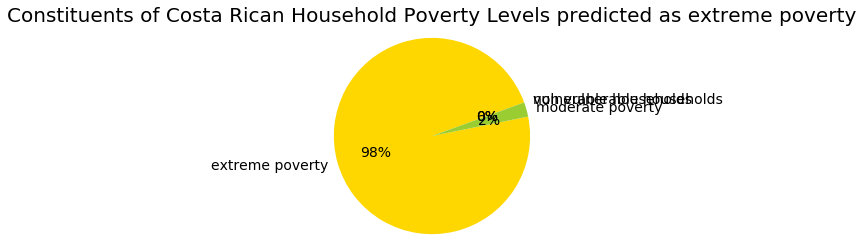

In [20]:
p11, p21, p31, p41 = getConstituentsOfPredicted(cf,1,angle=20)

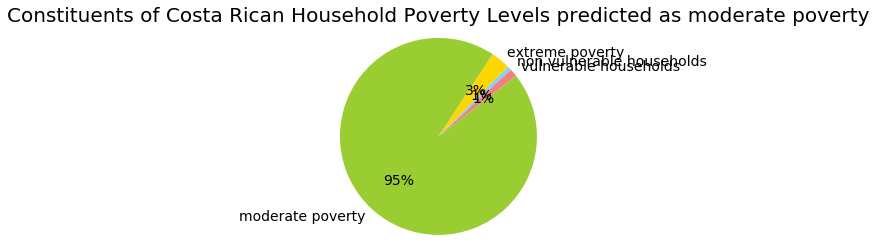

In [21]:
p12, p22, p32, p42 = getConstituentsOfPredicted(cf,2,angle=45)

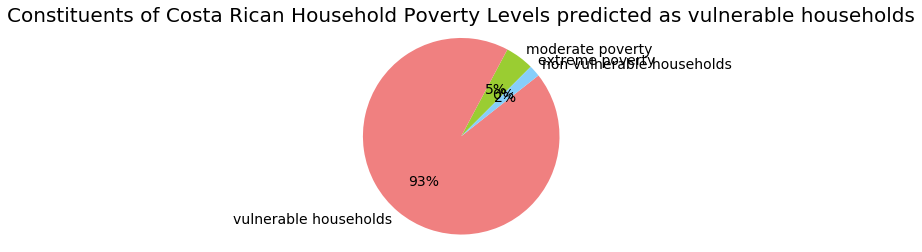

In [22]:
p13, p23, p33, p43 = getConstituentsOfPredicted(cf,3,angle=45)

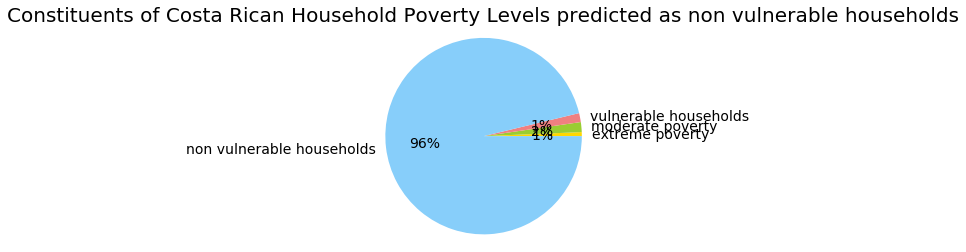

In [23]:
p14, p24, p34, p44 = getConstituentsOfPredicted(cf,4,angle=0)

### Visualization - True Positives v.s. False Negatives

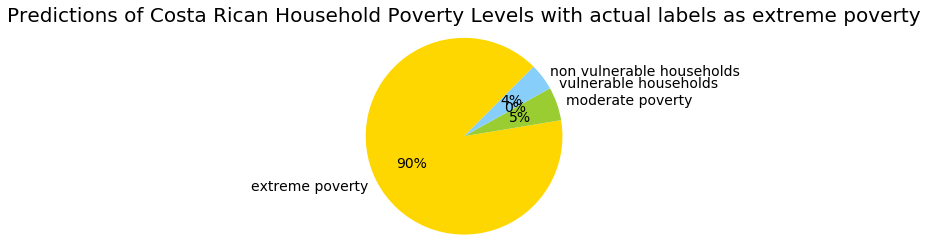

In [24]:
getPredictionOfActualLabels([p11,p12,p13,p14],cf,1,angle=45)

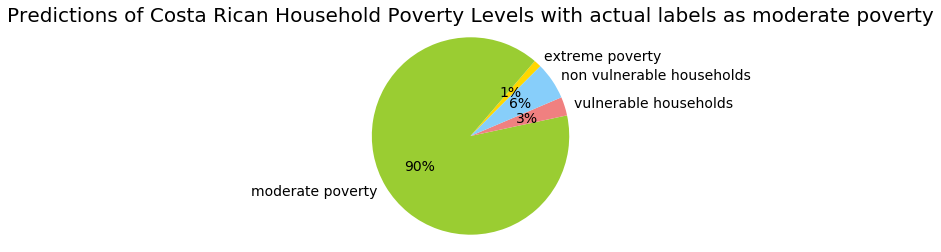

In [25]:
getPredictionOfActualLabels([p21,p22,p23,p24],cf,2,angle=45)

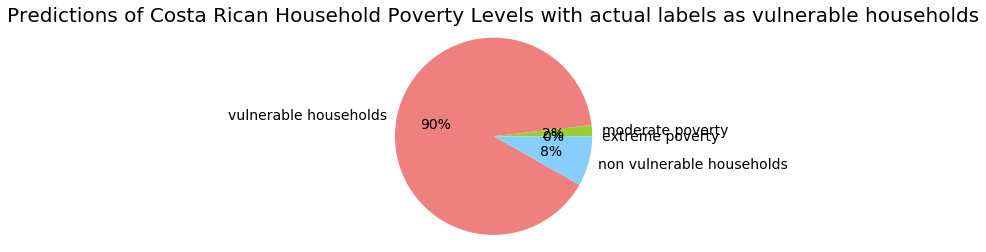

In [26]:
getPredictionOfActualLabels([p31,p32,p33,p34],cf,3,angle=0)

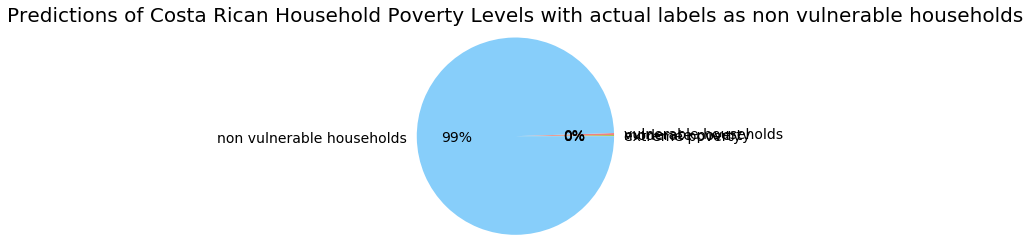

In [27]:
getPredictionOfActualLabels([p41,p42,p43,p44],cf,4,angle=0)

In [22]:
# See importance of features
features_importance = rf_model.feature_importances_
features_list=x_validate.columns.to_list()

print("Feature ranking:")
for i, data_class in enumerate(features_list):
    print("{}. {} ({})".format(i + 1, data_class, features_importance[i]))

Feature ranking:
1. v2a1 (0.014644378567707816)
2. hacdor (0.0024251306089850227)
3. hacapo (0.0014224952395702991)
4. v14a (0.000493466514940687)
5. refrig (0.0028746000803597615)
6. v18q (0.007892092488145017)
7. r4h1 (0.012349378423515682)
8. r4h2 (0.0218246011860923)
9. r4h3 (0.019440732964506133)
10. r4m1 (0.011927433745062686)
11. r4m2 (0.0197003996861234)
12. r4m3 (0.01936518257868291)
13. r4t1 (0.01859741751417509)
14. r4t2 (0.017025045954685625)
15. escolari (0.013415843742455441)
16. rez_esc (0.0011761509578364306)
17. paredblolad (0.009447720314462463)
18. paredzocalo (0.004620691736398711)
19. paredpreb (0.0069571932141864554)
20. pareddes (0.0005680968994385752)
21. paredmad (0.005129028090840263)
22. paredzinc (0.0007627992078730204)
23. paredfibras (0.00012763173965535239)
24. paredother (8.436579767095329e-05)
25. pisomoscer (0.00846695810524385)
26. pisocemento (0.007115446346103056)
27. pisoother (8.356510538680155e-06)
28. pisonatur (6.23281097075764e-05)
29. pisonot

Text(0.5, 1.0, 'Top 5 features that contibute to the classification by Random Forest')

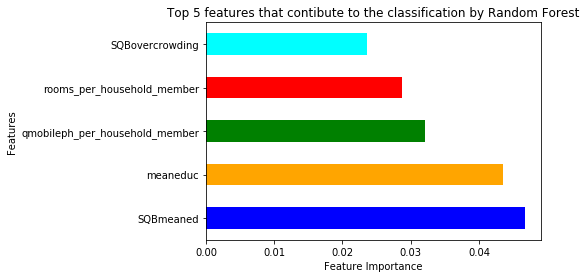

In [23]:
# Plot top 5 features with largest importance
colors=['blue', 'orange', 'green','red','cyan']
feat_importances = pd.Series(rf_model.feature_importances_, index=x_validate.columns)
feat_importances.nlargest(5).plot(kind='barh',color=colors)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 5 features that contibute to the classification by Random Forest")

## Submission for test

In [ ]:
# Test
# Read the test CSV Data
path = '/kaggle/input/costa-rican-household-poverty-prediction/test.csv'
test_data = pd.read_csv(path)
test_data = applyFE(test_data)
y_pred = rf_cv.predict(test_data)
# Read submission file
path = '/kaggle/input/costa-rican-household-poverty-prediction/sample_submission.csv'
test = pd.read_csv(path)
test['Target'] = y_pred
test.to_csv("rf.csv", index= False)
gc.collect()

# 4b. Model: XGBT

In [ ]:
# Change the data structure of x_train and y_train to a more efficient structure that XGBoost consists.
#data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)

In [9]:
# A parameter grid for XGBoost
params = {
        #'min_child_weight': [1, 5, 10],
        'gamma': [0.25,0.3],
        #'subsample': [0.5, 0.7, 1.0],
        #'colsample_bytree': [0.5, 0.8, 1.0],
        #'max_depth': [30, 35, 40],
        'reg_lambda': [0.3,0.35],
        #'learning_rate': [0.05, 0.1, 0.15]
        }

# Specify a scoring method
scorer = metrics.make_scorer(metrics.f1_score, average = 'weighted')
# Model initializer
xgb_c = xgb.XGBClassifier(objective = 'multi:softmax', num_class = 4, gamma = 0, colsample_bytree = 1, subsample=0.8, learning_rate = 0.15, max_depth = 35, min_child_weight = 1, n_estimators = 100, reg_lambda = 0.1)
# GridSearch
xgb_cv = GridSearchCV(estimator = xgb_c, param_grid = params, scoring = scorer, cv = 3)
# Fit train data
xgb_cv.fit(x_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None, colsample_bytree=1,
                                     gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,
                                     max_depth=35, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n...
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=0.1, scale_pos_weight=None,
                                     subsample=0.8, tree_method=None,


In [10]:
## View the accuracy score
print('Best score for training data:', xgb_cv.best_score_,"\n") 

## View the best parameters for the model found using grid search
print('Best parameters:',xgb_cv.best_params_,"\n")


Best score for training data: 0.9198921818061178 

Best parameters: {'gamma': 0.3, 'reg_lambda': 0.35} 



In [25]:
# Model initializer with best param values
xgb_c = xgb.XGBClassifier(objective = 'multi:softmax', num_class = 4, gamma = 0.3, colsample_bytree = 1, subsample=0.8, learning_rate = 0.15, max_depth = 35, min_child_weight = 1, n_estimators = 100, reg_lambda = 0.3)
# Fit train data
xgb_c.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=35,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=0.3, scale_pos_weight=None, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
# Predict and evaluate for train data
y_pred_train = xgb_cv.predict(x_train)
print("Classification report for rf model %s:\n%s\n"
      % (xgb_cv, metrics.classification_report(y_train, y_pred_train)))

Classification report for rf model GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None, colsample_bytree=1,
                                     gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,
                                     max_depth=35, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n...
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=0.1, scale_pos_weight=None,
                                   

In [12]:
# Predict and evaluate for validation data
y_pred_validate = xgb_cv.predict(x_validate)
print("Classification report for rf model %s:\n%s\n"
      % (xgb_cv, metrics.classification_report(y_validate, y_pred_validate)))

Classification report for rf model GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None, colsample_bytree=1,
                                     gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,
                                     max_depth=35, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n...
                                     objective='multi:softmax',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=0.1, scale_pos_weight=None,
                                   

# 4b. Evaluation: XGBT

**Target labels**

1 = extreme poverty ---> index 0

2 = moderate poverty ---> index 1

3 = vulnerable households ---> index 2

4 = non vulnerable households ---> index 3


### Visualization - True Positives v.s. False Positives

In [13]:
# Get confusion matrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_validate, y_pred_validate)
cf #cf[actu][pred]
# pred 0 1 2 3
# actu
# 0
# 1
# 2
# 3

array([[ 59,   7,   2,   5],
       [  6, 137,   4,   9],
       [  0,   8, 122,   7],
       [  0,   1,   4, 585]], dtype=int64)

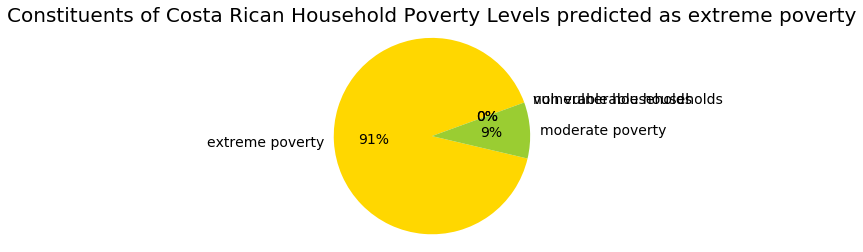

In [14]:
p11, p21, p31, p41 = getConstituentsOfPredicted(cf,1,angle=20)

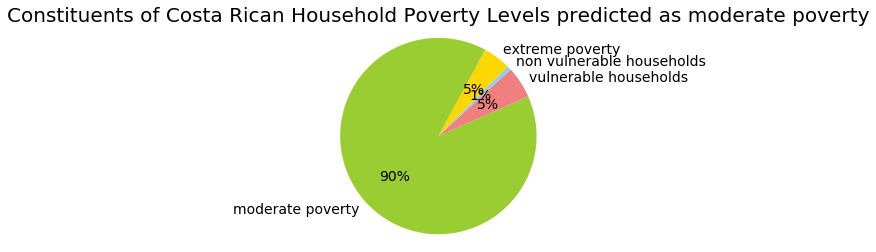

In [15]:
p12, p22, p32, p42 = getConstituentsOfPredicted(cf,2,angle=45)

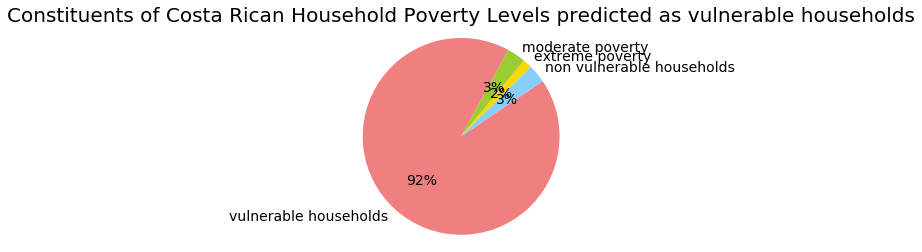

In [16]:
p13, p23, p33, p43 = getConstituentsOfPredicted(cf,3,angle=45)

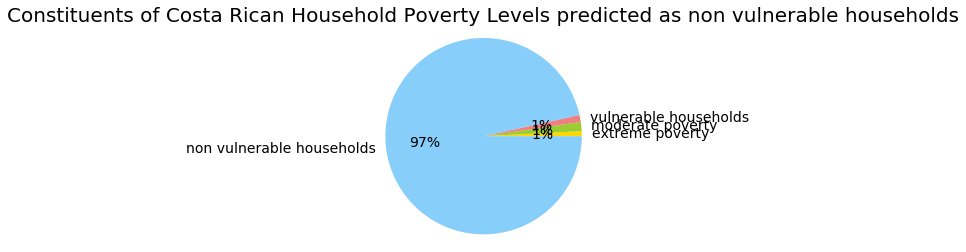

In [18]:
p14, p24, p34, p44 = getConstituentsOfPredicted(cf,4,angle=0)

### Visualization - True Positives v.s. False Negatives

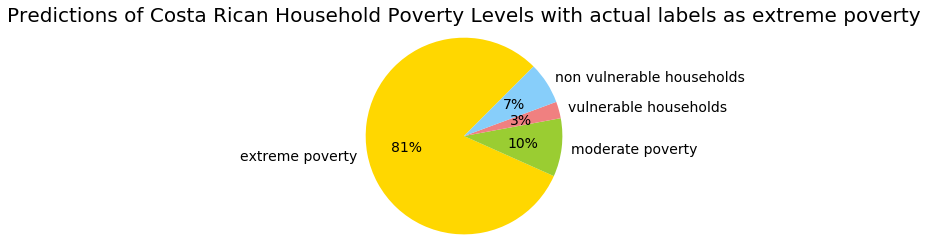

In [19]:
getPredictionOfActualLabels([p11,p12,p13,p14],cf,1,angle=45)

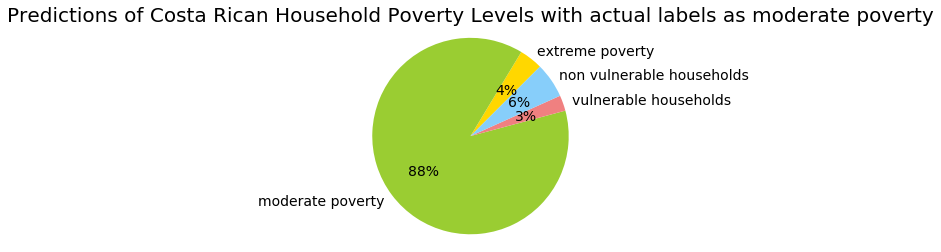

In [20]:
getPredictionOfActualLabels([p21,p22,p23,p24],cf,2,angle=45)

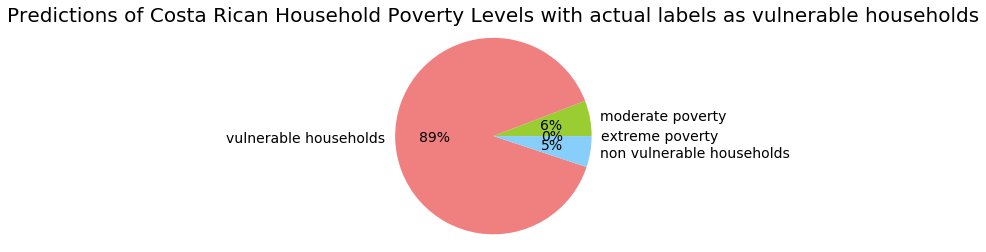

In [21]:
getPredictionOfActualLabels([p31,p32,p33,p34],cf,3,angle=0)

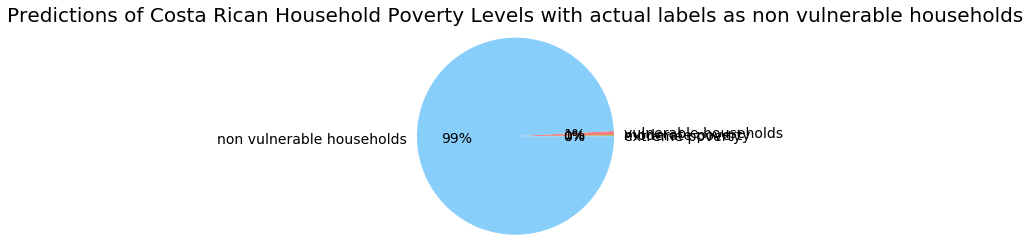

In [22]:
getPredictionOfActualLabels([p41,p42,p43,p44],cf,4,angle=0)

In [27]:
# See importanceof features
features_importance = xgb_c.feature_importances_
features_list=x_validate.columns.to_list()

print("Feature ranking:")
for i, data_class in enumerate(features_list):
    print("{}. {} ({})".format(i + 1, data_class, features_importance[i]))

Feature ranking:
1. v2a1 (0.010022498667240143)
2. hacdor (0.017247073352336884)
3. hacapo (0.01215685997158289)
4. v14a (0.019708648324012756)
5. refrig (0.00950594712048769)
6. v18q (0.012500722892582417)
7. r4h1 (0.010778884403407574)
8. r4h2 (0.009675094857811928)
9. r4h3 (0.00953168049454689)
10. r4m1 (0.010053088888525963)
11. r4m2 (0.00863244105130434)
12. r4m3 (0.0)
13. r4t1 (0.013334857299923897)
14. r4t2 (0.0)
15. escolari (0.004032703582197428)
16. rez_esc (0.003424622816964984)
17. paredblolad (0.011138323694467545)
18. paredzocalo (0.008475425653159618)
19. paredpreb (0.007657061330974102)
20. pareddes (0.005128980148583651)
21. paredmad (0.009630857966840267)
22. paredzinc (0.004803498275578022)
23. paredfibras (0.0)
24. paredother (0.025090044364333153)
25. pisomoscer (0.009883620776236057)
26. pisocemento (0.007524430751800537)
27. pisoother (0.0)
28. pisonatur (0.0)
29. pisonotiene (0.008568333461880684)
30. pisomadera (0.010406671091914177)
31. techozinc (0.0064839143

Text(0.5, 1.0, 'Top 5 features that contibute to the classification by XGBT')

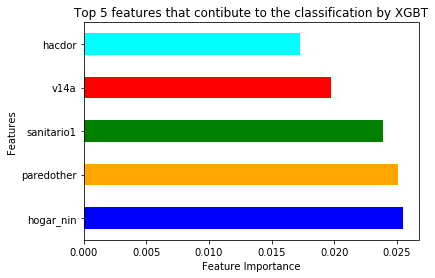

In [29]:
# Plot top 5 features of largest importance
colors=['blue', 'orange', 'green','red','cyan']
feat_importances = pd.Series(xgb_c.feature_importances_, index=x_validate.columns)
feat_importances.nlargest(5).plot(kind='barh',color=colors)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 5 features that contibute to the classification by XGBT")

# Submission for Test

In [ ]:
# Test
# Read the test CSV Data
path = '/kaggle/input/costa-rican-household-poverty-prediction/test.csv'
test_data = pd.read_csv(path)
test_data = applyFE(test_data)
y_pred = xgb_cv.predict(test_data)
# Read submission file
path = '/kaggle/input/costa-rican-household-poverty-prediction/sample_submission.csv'
test = pd.read_csv(path)
test['Target'] = y_pred
test.to_csv("xgbt.csv", index= False)
gc.collect()